In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from numpy import ndarray as ndarray
from typing import Tuple, Dict, List

In [ ]:
def plot_environment(env):
    plt.imshow(env, cmap='binary')
    plt.show()

def get_circle(radius: int, center: Tuple[int, int], env_size: Tuple[int, int]) -> ndarray:
    layer: ndarray = np.zeros(env_size)
    for y in range(env_size[0]):
        for x in range(env_size[1]):
            if (y - center[0])**2+(x - center[1])**2 <= radius**2:
                layer[y,x] = 1
    return layer


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
def random_circle_dynamic_env(env_size: Tuple[int, int], n_circles: int, n_frames: int = 1, proportion_objs_moving: float = 0.5) -> List[ndarray]:
    frame_list: List[ndarray] = []
    object_list: List[ndarray] = []

    # initialization of environment and objects
    
    for _ in range(n_circles):
        radius: int = np.random.choice(np.arange(10))
        center_y, center_x = np.random.choice(np.arange(env_size[0])), np.random.choice(np.arange(env_size[0]))
        circle: ndarray = get_circle(radius, (center_y, center_x), env_size)
        object_list.append(circle)
    frame: ndarray = sum(object_list)
    frame_list.append(frame)
    # plot_environment(frame)

    object_dict: Dict[ndarray] = dict()

    # dynamic environment gets multiple frames
    if n_frames > 1:
        moving_objects: int = []
        static_objects = []
        for object in object_list: # 50% of the objects are moving
            if np.random.random() > proportion_objs_moving:
                moving_objects.append(object)
            else:
                static_objects.append(object)
        
        
        for id, object in enumerate(moving_objects): # each object gets a direction, speed
        
            direction: str = np.random.choice(('UP', 'DOWN', 'LEFT', 'RIGHT'))
            speed: int = np.random.choice(np.arange(1,4))
            object_dict[id] = (direction, speed)
        
        for frame in range(1,n_frames):
            updated_moving_objects: List[ndarray] = []
            for id, object in enumerate(moving_objects):
                direction, speed = object_dict[id]
                updated_object: ndarray = np.zeros(env_size)

                reset: bool = False
                for y in range(env_size[0]):
                    for x in range(env_size[0]):
                        if object[y][x] == 1:
                            match direction:
                                case 'UP': 
                                    if y >= speed:
                                        updated_object[y-speed][x] = 1
                                    else:
                                        object_dict[id] = 'DOWN' , speed
                                        reset = True
                                case 'DOWN': 
                                    if y < env_size[0] - speed:
                                        updated_object[y+speed][x] = 1
                                    else:
                                        object_dict[id] = 'UP', speed
                                        reset = True
                                case 'LEFT': 
                                    if x >= speed:
                                        updated_object[y][x-speed] = 1
                                    else:
                                        object_dict[id] = 'RIGHT', speed
                                        reset = True
                                case 'RIGHT': 
                                    if x < env_size[0] - speed:
                                        updated_object[y][x+speed] = 1
                                    else:
                                        object_dict[id] = 'LEFT', speed
                                        reset = True
                if reset: 
                    updated_object = object
                updated_moving_objects.append(updated_object)
            moving_objects = updated_moving_objects
            frame = sum((*moving_objects, *static_objects))
            frame_list.append(frame)
    return frame_list



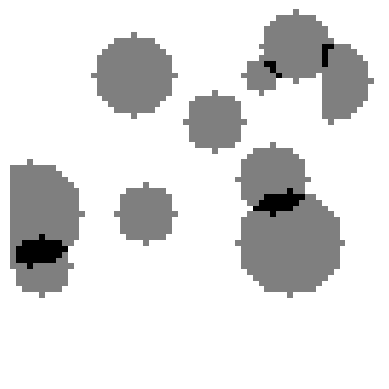

In [13]:
from PIL import Image
import numpy as np
from numpy import ndarray as ndarray
import matplotlib.pyplot as plt

frames: List[Image.Image] = []
frame_list: List[ndarray] = random_circle_dynamic_env((64,64), 10, 20)

for frame in frame_list:
    plt.imshow(frame, cmap='binary')
    plt.axis('off')


    plt.savefig("temp.png", bbox_inches='tight', pad_inches=0)
    frames.append(Image.open("temp.png"))

# save as GIF
frames[0].save(
    "maze_animation.gif",
    save_all=True,
    append_images=frames[1:],
    duration=100,
    loop=0
)

In [24]:
import numpy as np
import random
from collections import deque
from typing import Tuple, Deque

import numpy as np
import random
from collections import deque
from typing import Tuple, Deque, Optional

def create_flexible_grid_maze(
    width: int, 
    height: int, 
    cell_size: int, 
    break_density: float = 0.0
) -> np.ndarray:
    """
    Generates a grid-based maze, pads it to the requested dimensions, 
    and optionally introduces cycles by breaking walls.

    Args:
        width: The total desired width of the final maze array.
        height: The total desired height of the final maze array.
        cell_size: The size of the square chamber (e.g., 2 for a 2x2 chamber).
        break_density: The probability (0.0 to 1.0) of any internal wall segment 
                       being converted to a path (0) to create loops/cycles. 
                       Default is 0.0 (perfect maze).

    Returns:
        A 2D NumPy array of zeros (path) and ones (wall).
    """
    
    # --- 1. Setup and Dimension Calculation ---
    cell_dim_size = cell_size + 1 

    num_rows = (height - 1) // cell_dim_size
    num_cols = (width - 1) // cell_dim_size

    if num_rows <= 0 or num_cols <= 0:
        raise ValueError("Width and Height are too small for the given cell_size.")

    # Core maze dimensions (the actual generated part, excluding requested padding)
    maze_core_height = 1 + num_rows * cell_dim_size
    maze_core_width = 1 + num_cols * cell_dim_size

    # Initialize the core maze with walls (1) and visited grid
    maze_core: np.ndarray = np.ones((maze_core_height, maze_core_width), dtype=np.uint8)
    visited: np.ndarray = np.zeros((num_rows, num_cols), dtype=bool)

    # Helper function
    def get_maze_coords(r: int, c: int) -> Tuple[int, int]:
        y = 1 + r * cell_dim_size
        x = 1 + c * cell_dim_size
        return y, x

    # --- 2. DFS Maze Generation (Perfect Maze) ---
    start_r, start_c = random.randint(0, num_rows - 1), random.randint(0, num_cols - 1)
    stack: Deque[Tuple[int, int]] = deque([(start_r, start_c)])
    visited[start_r, start_c] = True

    start_y, start_x = get_maze_coords(start_r, start_c)
    maze_core[start_y : start_y + cell_size, start_x : start_x + cell_size] = 0

    while stack:
        current_r, current_c = stack[-1]
        
        possible_moves = [(0, 1, 'R'), (0, -1, 'L'), (1, 0, 'D'), (-1, 0, 'U')] 
        random.shuffle(possible_moves)
        
        neighbors = []
        for dr, dc, direction in possible_moves:
            next_r, next_c = current_r + dr, current_c + dc
            
            if 0 <= next_r < num_rows and 0 <= next_c < num_cols and not visited[next_r, next_c]:
                neighbors.append((next_r, next_c, dr, dc, direction))

        if neighbors:
            next_r, next_c, dr, dc, direction = neighbors[0]

            # 1. Carve path for the new chamber
            next_y, next_x = get_maze_coords(next_r, next_c)
            maze_core[next_y : next_y + cell_size, next_x : next_x + cell_size] = 0

            # 2. Carve the wall passage between cells
            curr_y, curr_x = get_maze_coords(current_r, current_c)

            if direction == 'R':
                wall_y, wall_x = curr_y, curr_x + cell_size
                maze_core[wall_y : wall_y + cell_size, wall_x] = 0
            elif direction == 'L':
                wall_y, wall_x = next_y, next_x + cell_size
                maze_core[wall_y : wall_y + cell_size, wall_x] = 0
            elif direction == 'D':
                wall_y, wall_x = curr_y + cell_size, curr_x
                maze_core[wall_y, wall_x : wall_x + cell_size] = 0
            elif direction == 'U':
                wall_y, wall_x = next_y + cell_size, next_x
                maze_core[wall_y, wall_x : wall_x + cell_size] = 0
            
            # 3. Push new cell onto stack
            visited[next_r, next_c] = True
            stack.append((next_r, next_c))
        else:
            stack.pop()

    # --- 3. Optional Wall Breaking (Introducing Cycles) ---
    if break_density > 0.0:
        # 1. Horizontal Walls (Rows separating cells)
        for r in range(num_rows):
            wall_y = 1 + (r + 1) * cell_dim_size - 1
            if wall_y < maze_core_height - 1: # Only operate on internal walls
                for c in range(num_cols):
                    wall_x_start = 1 + c * cell_dim_size
                    wall_x_end = wall_x_start + cell_size

                    # Only break if it's currently a wall (1) and based on density
                    if maze_core[wall_y, wall_x_start] == 1 and random.random() < break_density:
                        maze_core[wall_y, wall_x_start : wall_x_end] = 0

        # 2. Vertical Walls (Columns separating cells)
        for c in range(num_cols):
            wall_x = 1 + (c + 1) * cell_dim_size - 1
            if wall_x < maze_core_width - 1: # Only operate on internal walls
                for r in range(num_rows):
                    wall_y_start = 1 + r * cell_dim_size
                    wall_y_end = wall_y_start + cell_size

                    # Only break if it's currently a wall (1) and based on density
                    if maze_core[wall_y_start, wall_x] == 1 and random.random() < break_density:
                        maze_core[wall_y_start : wall_y_end, wall_x] = 0


    # --- 4. Padding to Requested Dimensions ---
    final_maze: np.ndarray = np.ones((height, width), dtype=np.uint8)
    
    # Place the generated core maze (with or without cycles) into the top-left corner
    final_maze[0:maze_core_height, 0:maze_core_width] = maze_core
    
    return final_maze

mymaze = create_flexible_grid_maze(64, 64, 2, 0.2)


# write to maze file
with open("myfile.txt", "w", encoding="utf-8") as f:
    for row in mymaze:
        for char in row:
            f.write('1' if char == 1 else ' ')
        f.write('\n')
